In [ ]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from Modelos   import *
from FuncsChern import *

import matplotlib.pyplot as plt

plt.rcParams.update({
    'text.usetex':    True,
    'font.family':    'serif',
    'font.serif':     ['Computer Modern'], 
    'axes.unicode_minus': False,
    'text.latex.preamble': r'\usepackage{amsfonts}',
})

plt.rcParams.update({
    "font.size": 18,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
})

def createletters(axs, Axis3D=[], coord=[0.08, 0.92], ni=0, SMALL_SIZE=20):
    import numpy as np
    letters = [r'\textbf{(a)}', r'\textbf{(b)}', r'\textbf{(c)}', r'\textbf{(d)}', r'\textbf{(e)}', r'\textbf{(f)}',
               r'\textbf{(g)}', r'\textbf{(h)}',r'\textbf{(i)}']
    axs = np.ravel(axs)
    for n, ax in enumerate(axs):
        if n in Axis3D:
            ax.text2D(coord[0], coord[1], letters[max([n, ni])], transform=ax.transAxes, size=SMALL_SIZE, weight='bold')
        else:
            ax.text(coord[0], coord[1], letters[max([n, ni])], transform=ax.transAxes, size=SMALL_SIZE, weight='bold')


[1/5] Computing k-mesh …
[2/5] Sweep (a) – G vs Δ  (μ = μ₀)


G–DELTA grid:   0%|          | 0/251001 [00:00<?, ?it/s]

[3/5] Sweep (b) – μ vs Δ  (G = G₀)


mu–DELTA grid:   0%|          | 0/251001 [00:00<?, ?it/s]

[4/5] Sweep (c) – μ vs G  (Δ = Δ₀)


mu–G grid:   0%|          | 0/251001 [00:00<?, ?it/s]

[4b/5]  Sweep (inset) μ vs G …


mu–G grid:   0%|          | 0/160801 [00:00<?, ?it/s]

[5/5] Plotting …


UsageError: Line magic function `%fig.savefig("triple_param_scan.pdf",` not found.


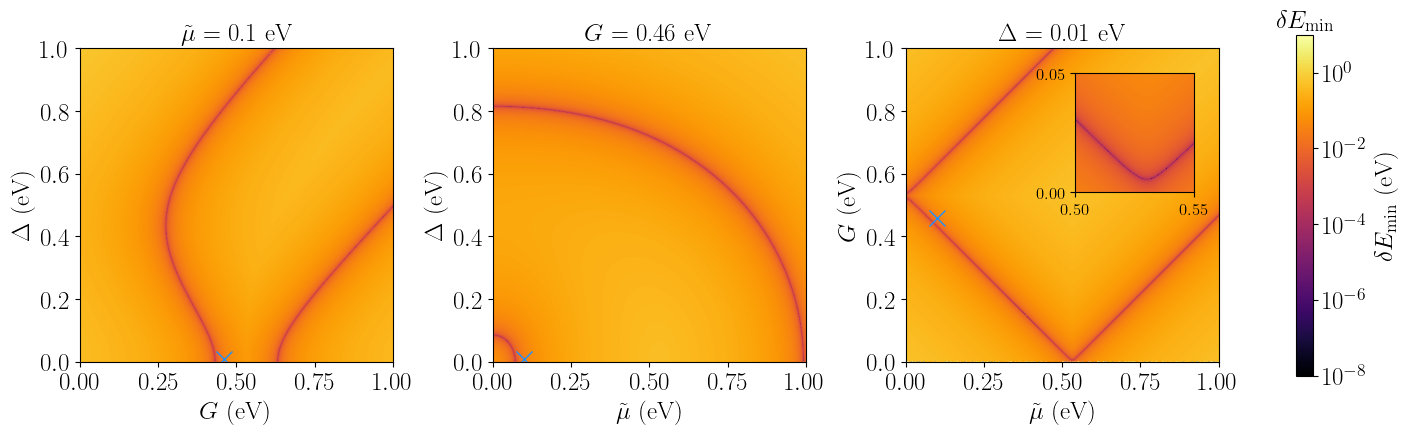

In [ ]:
from __future__ import annotations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm           # ← NUEVO
from joblib import Parallel, delayed
from tqdm.auto import tqdm

# ───────────────────────────────────────── MODELO Y CONSTANTES ─────────────────────────────────────────
MU0, G0, DELTA0 = 0.10, 0.46, 0.01     # valores ancla (eV)
T               = 0.45                 # ruptura TRS (eV)

NK           = 2           # puntos por eje k  →  kx, ky ∈ [0, π/a]
AXIS_POINTS  = 501         # resolución de los ejes de parámetros

a_lat = 4.0                # parámetro de red (Å)

G_vals     = np.linspace(0.0, 1.0, AXIS_POINTS)   # eV
DELTA_vals = np.linspace(0.0, 1.0, AXIS_POINTS)   # eV
MU_vals    = np.linspace(0.0, 1.0, AXIS_POINTS)   # eV

# Rango de la escala logarítmica para los gaps ------------------------
clip_lo, clip_hi = 1e-8, 1e+1            # eV

# ──────────────────────────────── MALLA k PRECALCULADA ────────────────────────────────
print("[1/5] Computing k-mesh …")
kx_pts = np.linspace(0.0, np.pi/a_lat, NK)
ky_pts = np.linspace(0.0, np.pi/a_lat, NK)

kxg, kyg = np.meshgrid(kx_pts, ky_pts, indexing="ij")      # (Nk,Nk)
cos_kx, cos_ky = np.cos(kxg * a_lat), np.cos(kyg * a_lat)
sin_kx, sin_ky = np.sin(kxg * a_lat), np.sin(kyg * a_lat)

M_grid = -0.28 + 2*56.6 / a_lat**2 * (2.0 - cos_kx - cos_ky)
A_grid =  4.1  / a_lat * np.hypot(sin_kx, sin_ky)

N_KPOINTS = NK * NK

# ───────────────────────────── CUÁRTICO – COEFICIENTES ─────────────────────────────
def quartic_coeffs_grid(mu: float, G: float, D: float) -> np.ndarray:
    eps = mu

    D0 = eps**2 + D**2 - M_grid**2 - A_grid**2 - G**2 - T**2
    b0 =  4*G**2 * (M_grid**2 + T**2) - 4*D**2 * (M_grid**2 + A_grid**2)
    b1 =  4 * (eps**2 + D**2)

    g0 = -64 * G**2 * T**2 * D**2 * A_grid**2
    g1 =  64 * G**2 * (eps**2*M_grid**2 + eps**2*T**2 + T**2*D**2)

    a1 = 2*D0 - b1
    a0 = D0**2 - b0

    coeffs = np.stack([np.ones_like(a0),
                       2*a1,
                       a1**2 + 2*a0,
                       2*a0*a1 - g1,
                       a0**2 - g0], axis=-1)
    return coeffs.reshape(-1, 5)

# ───────────────────────────── GAP LOCAL (un k) ─────────────────────────────
def local_gap_from_coeffs(c: np.ndarray, tol: float = 1e-12) -> float:
    roots = np.roots(c)
    s = roots.real[np.isreal(roots) & (roots.real > tol)]
    if s.size < 2:
        return np.inf
    E = np.sort(np.concatenate((-np.sqrt(s), np.sqrt(s))))
    pos = E[E > 0.0]
    return pos.min() if pos.size else np.inf

# ───────────────────────────── GAP GLOBAL (malla completa) ─────────────────────────────
def global_gap(mu: float, G: float, D: float) -> float:
    coeffs = quartic_coeffs_grid(mu, G, D)
    g_min = np.inf
    for c in coeffs:                        # bucle sobre k, sin trigonometría
        gap = local_gap_from_coeffs(c)
        if gap < g_min:
            g_min = gap
            if g_min == 0.0:
                break
    return g_min

# ───────────────────────────── BARRIDO 2-D EN PARALELO ─────────────────────────────
def sweep_2D_parallel(axis1: np.ndarray, axis2: np.ndarray,
                      fixed: dict[str, float],
                      names: tuple[str, str]) -> np.ndarray:
    total = len(axis1) * len(axis2)

    def calc(idx: int) -> float:
        i = idx // len(axis2)
        j = idx %  len(axis2)
        pars = {names[0]: axis1[i], names[1]: axis2[j], **fixed}
        return global_gap(pars['mu'], pars['G'], pars['DELTA'])

    results = Parallel(n_jobs=-1)(
        delayed(calc)(idx) for idx in tqdm(range(total), desc=f"{names[0]}–{names[1]} grid"))
    return np.asarray(results).reshape(len(axis1), len(axis2))

# ───────────────────────────── MAIN ─────────────────────────────
def main():
    print("[2/5] Sweep (a) – G vs Δ  (μ = μ₀)")
    panel_a = sweep_2D_parallel(G_vals, DELTA_vals,
                                fixed={'mu': MU0}, names=('G', 'DELTA'))

    print("[3/5] Sweep (b) – μ vs Δ  (G = G₀)")
    panel_b = sweep_2D_parallel(MU_vals, DELTA_vals,
                                fixed={'G': G0}, names=('mu', 'DELTA'))

    print("[4/5] Sweep (c) – μ vs G  (Δ = Δ₀)")
    panel_c = sweep_2D_parallel(MU_vals, G_vals,
                                fixed={'DELTA': DELTA0}, names=('mu', 'G'))

    # ───────── Zoom (alta resolución)
    MU_zoom = np.linspace(0.50, 0.55, 401)
    G_zoom  = np.linspace(0.00, 0.05, 401)
    print("[4b/5]  Sweep (inset) μ vs G …")
    panel_zoom = sweep_2D_parallel(MU_zoom, G_zoom,
                                   fixed={'DELTA': DELTA0},
                                   names=('mu', 'G'))

    # ───────── Figura
    print("[5/5] Plotting …")
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.3), constrained_layout=True)
    cmap = "inferno"
    norm = LogNorm(vmin=clip_lo, vmax=clip_hi)

    img_a = axes[0].imshow(panel_a.T, origin="lower",
                           extent=[G_vals[0], G_vals[-1],
                                   DELTA_vals[0], DELTA_vals[-1]],
                           cmap=cmap, norm=norm)
    img_b = axes[1].imshow(panel_b.T, origin="lower",
                           extent=[MU_vals[0], MU_vals[-1],
                                   DELTA_vals[0], DELTA_vals[-1]],
                           cmap=cmap, norm=norm)
    img_c = axes[2].imshow(panel_c.T, origin="lower",
                           extent=[MU_vals[0], MU_vals[-1],
                                   G_vals[0],   G_vals[-1]],
                           cmap=cmap, norm=norm)

    axes[0].set_xlabel(r'$G$ (eV)');     axes[0].set_ylabel(r'$\Delta$ (eV)');  axes[0].set_title(r'$\tilde{\mu}$ = 'f'{MU0} eV')
    axes[1].set_xlabel(r'$\tilde{\mu}$ (eV)');     axes[1].set_ylabel(r'$\Delta$ (eV)');  axes[1].set_title(r'$G$ = 'f'{G0} eV')
    axes[2].set_xlabel(r'$\tilde{\mu}$ (eV)');     axes[2].set_ylabel(r'$G$ (eV)');  axes[2].set_title(r'$\Delta$ = 'f'{DELTA0} eV')
    
    axes[0].plot(G0,      DELTA0, c='dodgerblue', marker='x', markersize=12)
    axes[1].plot(MU0,     DELTA0, c='dodgerblue', marker='x', markersize=12)
    axes[2].plot(MU0,     G0,     c='dodgerblue', marker='x', markersize=12)

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    axins = inset_axes(axes[2], width="38%", height="38%",
                       loc="upper right", borderpad=1.0)

    axins.imshow(panel_zoom.T, origin="lower",
                 extent=[MU_zoom[0], MU_zoom[-1],
                         G_zoom[0],   G_zoom[-1]],
                 cmap=cmap, norm=norm,
                 interpolation="nearest", aspect="auto")

    axins.set_xlim(0.50, 0.55)
    axins.set_ylim(0.00, 0.05)
    axins.set_xticks([0.50, 0.55])
    axins.set_yticks([0.00, 0.05])
    axins.tick_params(labelsize=12)

    cb = fig.colorbar(img_c, ax=axes.ravel().tolist(),
                      shrink=0.9,
                      label=r'$\delta E_{\min}$ (eV)')
    cb.ax.set_title(r'$\delta E_{\min}$')

    #fig.savefig("triple_param_scan.pdf", dpi=300)

if __name__ == "__main__":
    main()

## Nanorribon 

In [6]:
import sys
import kwant

sys.path.append('..')

from FuncsChern import *
import numpy as np
#import kwant

# Pauli matrices
sx = np.array([[0, 1],[1, 0]], dtype=complex)
sy = np.array([[0, -1j],[1j, 0]], dtype=complex)
sz = np.array([[1, 0],[0, -1]], dtype=complex)
s0 = np.eye(2, dtype=complex)

def kron3(A, B, C):
    return np.kron(np.kron(A, B), C)

def Matrices_Gamma():

    Gz00 = kron3(sz,s0,s0)
    Gz0z = kron3(sz,s0,sz)
    G00x = kron3(s0,s0,sx)
    Gzzy = kron3(sz,sz,sy)
    Gzzz = kron3(sz,sz,sz)
    G0yy = kron3(s0,sy,sy)
    Gzyy = kron3(sz,sy,sy)
    Gzxx = kron3(sz,sx,sx)
    Gyyz = kron3(sy,sy,sz)
    Gyy0 = kron3(sy,sy,s0)

    return Gz00, Gz0z, G00x, Gzzy, Gzzz, G0yy, Gyyz, Gzyy, Gyy0

Gz00, Gz0z, G00x, Gzzy, Gzzz, G0yy, Gyyz, Gzyy, Gyy0 = Matrices_Gamma()


def Ribbon_BHZ_SC(params):
    a = params["a"]
    L = params["L"]
    lat = kwant.lattice.chain(a,norbs=8)

    def OS(site, kx, a, C0, C2, M0, M2, A,G,T,Delta):
            ck2_xy = 2.0 - np.cos(kx * a)
            epsilon_0 = C0 + (2 * C2 / (a ** 2)) * ck2_xy
            M_0 = M0 + (2 * M2 / (a ** 2)) * ck2_xy
            
            OS_matrix = (
                epsilon_0 * Gz00 +
                M_0 * Gz0z +
                (A / a) * (np.sin(kx * a) * G00x )+
                G * Gzzz +
                T * Gzyy +
                Delta * Gyyz
            )
            return OS_matrix

    def HOP(site1, site2, a, C2, M2, A):
            HOP_matrix = (
                -(1 / a ** 2) * (C2 * Gz00 + M2 * Gz0z) +
                (1j * A) / (2 * a) * Gzzy
            )
            
            return HOP_matrix

    syst = kwant.Builder()
    
    for z in range(int(L//a)+1):
        syst[lat(z)] = OS
    syst[kwant.builder.HoppingKind((1,), lat, lat)] = HOP


    return syst.finalized()

In [7]:
H_params = {
        "L":350*4 , 
        'C0':0.1,
    'C2':0.,
    'M0':-0.28,
    'M2':56,
    'A':4.1,
    'a':4,
    'G':0.46,
    'T':0.45,
    'Delta':0.01
            }

syst = Ribbon_BHZ_SC(H_params)

In [8]:
# Eigensystem solution

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

Npts = 35
a=H_params['a']
kx_vals = np.linspace(-0.03, 0.03, Npts) 

E_all = []
vec_all = []
for kx in tqdm(kx_vals):
    H_params["kx"] = kx
    H = syst.hamiltonian_submatrix(params=H_params)
    E,vec = np.linalg.eigh(H)
    E_all.append(np.sort(E))
    vec_all.append(vec)
E_all = np.array(E_all)
vec_all = np.array(vec_all)

  0%|          | 0/35 [00:00<?, ?it/s]

In [9]:
# Charge operator

Q_mat = np.kron(np.eye(351), kron3(sz, s0, s0))

Nk, Nb = E_all.shape
Q_expect = np.empty((Nk, Nb))

Q_expect = np.einsum(
    'kan,ac,kcn->kn',                
    np.conj(vec_all),        
    Q_mat,                           
    vec_all,                 
    optimize=True
).real 

Bandas en k=20:  menor → 1403  E=-0.0012 eV ;  2ª menor → 1404  E=0.0012 eV


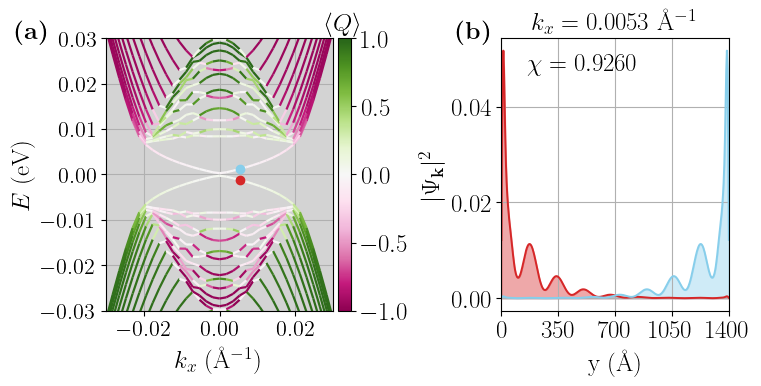

In [10]:
s0 = np.eye(2, dtype=complex)
sx = np.array([[0, 1], [1, 0]], dtype=complex)

def kron3(a, b, c):
    return np.kron(a, np.kron(b, c))

a = 4                    
L = 351
total_length = L * a-4
Npts        = len(kx_vals)
nbands      = E_all.shape[1]


vec_all = vec_all.reshape(Npts, 8 * L, nbands)
Dense = kwant.operator.Density(syst, kron3(s0, s0, s0))


k_idx = Npts // 2 + 3           

energies_k = E_all[k_idx, :]
band0, band1 = np.argsort(np.abs(energies_k))[:2]   
E0, E1 = energies_k[[band0, band1]]

print(f"Bandas en k={k_idx}:  menor → {band0}  E={E0:.4f} eV ;"
      f"  2ª menor → {band1}  E={E1:.4f} eV")

u0 = vec_all[k_idx, :, band0]       
u1 = vec_all[k_idx, :, band1]

dens0 = Dense(u0)
dens1 = Dense(u1)

C_mat = np.kron(np.eye(L), kron3(sx, s0, s0))

chi0 = np.abs(np.vdot(u0, C_mat @ np.conj(u0)))**2
chi1 = np.abs(np.vdot(u1, C_mat @ np.conj(u1)))**2


from matplotlib.collections import LineCollection

cells   = np.arange(len(dens0))
lengths = cells * a

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10*0.75,5*0.75), constrained_layout=True)

cmap = plt.cm.PiYG
norm = plt.Normalize(vmin=-1, vmax=1)





for j in range(Nb):
    x = kx_vals                     
    y = E_all[:, j]                
    q = Q_expect[:, j]                 

    pts      = np.column_stack([x, y]).reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)   # (Nk-1, 2, 2)

    q_seg = 0.5 * (q[:-1] + q[1:])      # (Nk-1,)

    lc = LineCollection(segments, cmap=cmap, norm=norm,
                        linewidths=1.6)
    lc.set_array(q_seg)
    ax1.add_collection(lc)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1, pad=0.02)
cbar.ax.set_title(r'$\langle Q\rangle$')


ax1.plot(kx_vals[k_idx], E0, 'o', color='tab:red',  ms=6,
         label=f'banda {band0}')
ax1.plot(kx_vals[k_idx], E1, 'o', color='skyblue', ms=6,
         label=f'banda {band1}')

ax1.set_xlim(-0.03, 0.03)
ax1.set_ylim(-0.03, 0.03)
ax1.set_xlabel(r'$k_x$ (Å$^{-1}$)', fontsize=18)
ax1.set_ylabel(r'$E$ (eV)', fontsize=18)
ax1.tick_params(axis='both', labelsize=16)
ax1.grid(True)
ax1.set_facecolor('lightgrey')

ax2.plot(lengths, dens0, '-', lw=1.4, color='tab:red')
ax2.fill_between(lengths, dens0, color='tab:red', alpha=0.4)
ax2.plot(lengths, dens1, '-', lw=1.4, color='skyblue')
ax2.fill_between(lengths, dens1, color='skyblue', alpha=0.4)

idx0 = np.argmax(dens0)            
idx1 = np.argmax(dens1)             

x0, y0 = lengths[idx0]*1.05, dens0[idx0]*0.9   
x1, y1 = 500, dens0[idx0]*0.9

ax2.text(x1, y1, rf'$\chi={chi1:.4f}$',
         color='k',  ha='center', va='bottom', fontsize=18)


ax2.set_xlabel("y (Å)", fontsize=18)
ax2.set_ylabel(r'$|\Psi_\mathbf{k}|^2$', fontsize=18)
ax2.tick_params(axis='both', labelsize=18)
ax2.set_xticks(np.arange(0, 1401, 350))
ax2.set_xlim(0, total_length)
ax2.set_title(fr'$k_x = {kx_vals[k_idx]:.4f}$ \AA$^{{-1}}$')
ax2.grid(True)

# lettering
ax1.text(-0.4, 1., r'\textbf{(a)}', transform=ax1.transAxes,
        size=18, weight='bold')
ax2.text(-0.2, 1., r'\textbf{(b)}', transform=ax2.transAxes,
         size=18, weight='bold')

#plt.tight_layout()
#plt.savefig('Figs/Fig_10Panel.pdf', bbox_inches='tight')
plt.show()

In [11]:
import sys, numpy, scipy, matplotlib, kwant, tqdm
print("Python:", sys.version.split()[0])
print("NumPy:  ", numpy.__version__)
print("SciPy:  ", scipy.__version__)
print("Matplotlib:", matplotlib.__version__)
print("Kwant:  ", kwant.__version__)
import tqdm as _tqdm
print("tqdm:   ", _tqdm.__version__)

Python: 3.12.2
NumPy:   1.26.4
SciPy:   1.13.1
Matplotlib: 3.10.0
Kwant:   1.5.0
tqdm:    4.66.5
